In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

Importing plotly failed. Interactive plots will not work.


In [2]:
# a function that take the data out of the whole dataset based on the given lat & lon
def dataExtractor(lat, lon):
    data = pd.read_csv("myRes.csv")
    column_names = data.columns
    dates = column_names[3:]
    
    temp_df = pd.DataFrame(columns=['date', 'temp'])
    temp_df['date'] = dates
    temp_df['date'] = pd.to_datetime(temp_df['date'])
    temperature = data[(data['LAT'] == lat) & (data['LON'] == lon)]
    temperature_value = temperature.iloc[0, 3:].values
    temp_df['temp'] = temperature_value
    temp_df = temp_df.rename(columns={'date': 'ds', 'temp': 'y'})
    return temp_df

# Prophet Model

In [3]:
def prophet_model(lat, lon, prediction_time_window):
    temp_df = dataExtractor(lat, lon)
    
    # Split the data to train and test data
    # i.e. Take data of the 11 months as training data and last month as the test data
    prediction_size = prediction_time_window
    train_data = temp_df[:-prediction_size]
    test_data = temp_df[-prediction_size:]
    model = Prophet()
    model.fit(train_data)
    future = model.make_future_dataframe(periods=prediction_size)
    forecast = model.predict(future)
    model.plot(forecast)
    t = model.plot_components(forecast)
    
    def make_comparison_dataframe(historical, forecast):
        return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))
    
    comparison_dataframe = make_comparison_dataframe(temp_df, forecast)
    
    axis_font = {'fontname':'Arial', 'size':'14'}
    plt.figure(figsize=(14, 8))
    plt.plot(comparison_dataframe['yhat'], label='Predicted value')
    plt.plot(comparison_dataframe['yhat_lower'], label='Lower bound prediction')
    plt.plot(comparison_dataframe['yhat_upper'], label='Upper bound prediction')
    plt.plot(comparison_dataframe['y'], label='Actual temperature', )
    plt.xlabel('Date', fontsize=20)
    plt.ylabel('Temperature', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.savefig('Comparison.pdf')
    plt.show()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


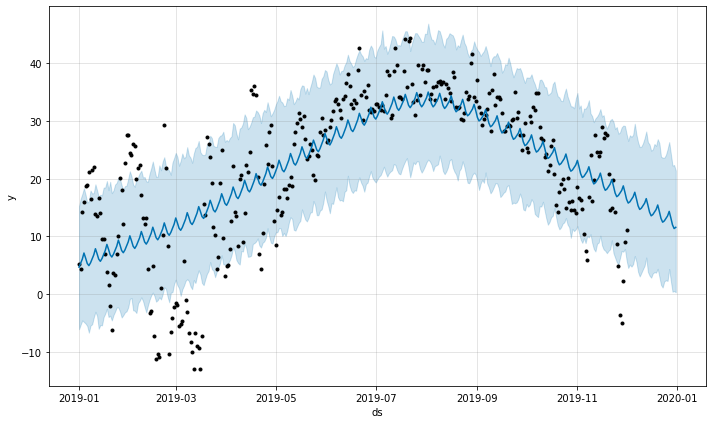

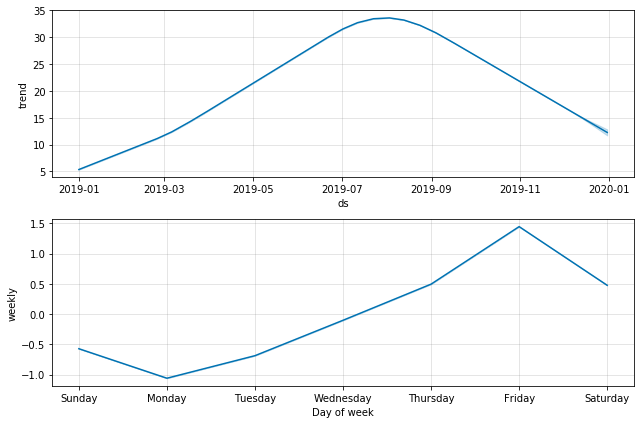

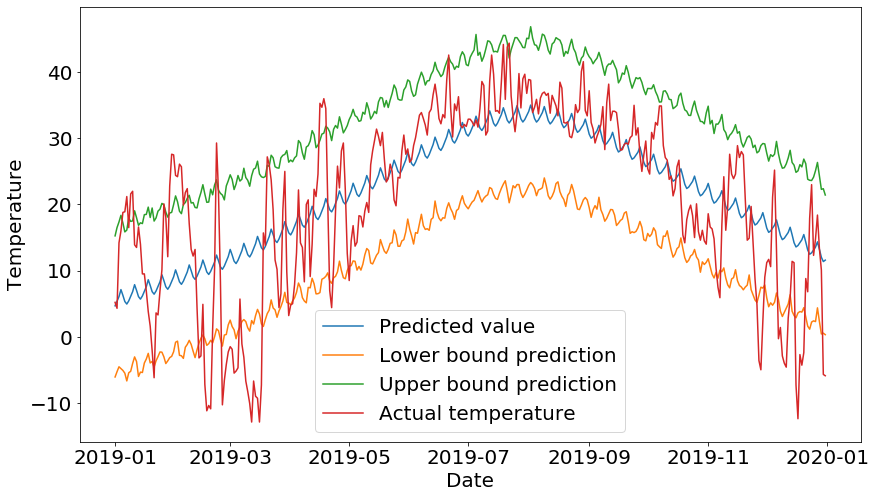

In [4]:
lat = 78.250
lon = 22.817
prophet_model(lat, lon, 30)

# AutoRegression (AR) Model

In [5]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

def AR_model(lat, lon, prediction_time_window):
    # load dataset
    temp_df = dataExtractor(lat, lon)
    
    # Date time temperature has two columns. The first column is the dates (01-01-2019 to 30-12-2019) and the second column
    # is the temperature. All these data are from one station.
    series = temp_df.set_index(['ds']).squeeze()
    # split dataset
    X = series.values
    
    train, test = X[1:len(X) - prediction_time_window], X[len(X) - prediction_time_window:]
    # train autoregression
    model = AutoReg(train, lags=prediction_time_window)
    model_fit = model.fit()
    print('Coefficients: %s' % model_fit.params)
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot results
    plt.plot(test, label='Test data')
    plt.plot(predictions, color='red', label='Predicted values')
    plt.ylabel('Temperature')
    plt.xlabel('Number of days in future')
    plt.legend()
    plt.show()

Coefficients: [ 0.60467906  1.02919316 -0.27736026  0.09656979 -0.0474902   0.06504887
 -0.06746133  0.1726922  -0.04390104 -0.01935103 -0.05816322  0.14018722
 -0.05818589 -0.04056744  0.08847843 -0.09294285  0.04506042 -0.054224
  0.08014693 -0.02340331  0.03343744 -0.09478179  0.11771045  0.0176635
 -0.01325152 -0.0997326   0.19619553  0.00308926  0.01716857 -0.03457533
 -0.10626584]
predicted=10.151777, expected=11.700000
predicted=6.861975, expected=10.600000
predicted=7.253081, expected=21.100000
predicted=10.166385, expected=25.200000
predicted=12.451520, expected=13.100000
predicted=15.191430, expected=-0.300000
predicted=16.715464, expected=1.400000
predicted=16.181613, expected=-2.900000
predicted=16.343064, expected=-4.000000
predicted=16.757127, expected=-4.600000
predicted=17.563617, expected=2.800000
predicted=17.650617, expected=5.900000
predicted=17.059001, expected=11.400000
predicted=17.452346, expected=11.200000
predicted=16.622049, expected=-7.300000
predicted=13.94

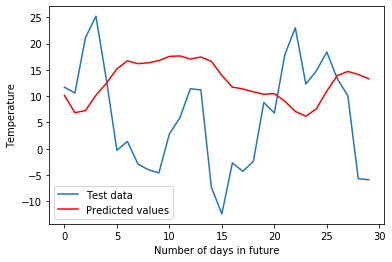

In [6]:
lat = 78.250
lon = 22.817
AR_model(lat, lon, 30)

# ARIMA Model

In [7]:
from statsmodels.tsa.arima_model import ARIMA

In [8]:
def ARIMA_model(lat, lon, prediction_time_window):
    # load dataset
    temp_df = dataExtractor(lat, lon)
    series = temp_df.set_index(['ds']).squeeze()
    X = series.values
    train, test = X[: len(X) - prediction_time_window], X[len(X) - prediction_time_window:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

predicted=10.630503, expected=11.700000
predicted=10.367414, expected=10.600000
predicted=8.737291, expected=21.100000
predicted=21.443491, expected=25.200000
predicted=23.344512, expected=13.100000
predicted=10.234197, expected=-0.300000
predicted=-0.112210, expected=1.400000
predicted=4.049520, expected=-2.900000
predicted=-2.476291, expected=-4.000000
predicted=-0.918230, expected=-4.600000
predicted=-2.610586, expected=2.800000
predicted=3.852058, expected=5.900000
predicted=5.341669, expected=11.400000
predicted=10.988494, expected=11.200000
predicted=9.434654, expected=-7.300000
predicted=-11.162959, expected=-12.400000
predicted=-9.782499, expected=-2.700000
predicted=0.388854, expected=-4.300000
predicted=-5.039673, expected=-2.400000
predicted=0.330702, expected=8.800000
predicted=9.685458, expected=6.800000
predicted=2.448045, expected=17.900000
predicted=18.905021, expected=23.000000
predicted=20.037504, expected=12.300000
predicted=8.114693, expected=14.800000
predicted=16.

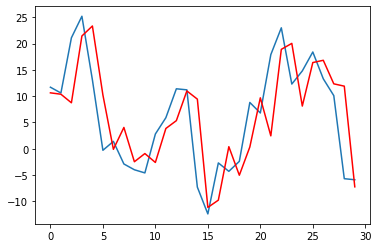

In [9]:
lat = 78.250
lon = 22.817
ARIMA_model(lat, lon, 30)